In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#Find the column names for the 'Measurement' table
measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [10]:
#Find the column names for the 'Station' table
station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [11]:
# Find the most recent date in the data set.
session.query(func.max(measurement.date)).scalar()

'2017-08-23'

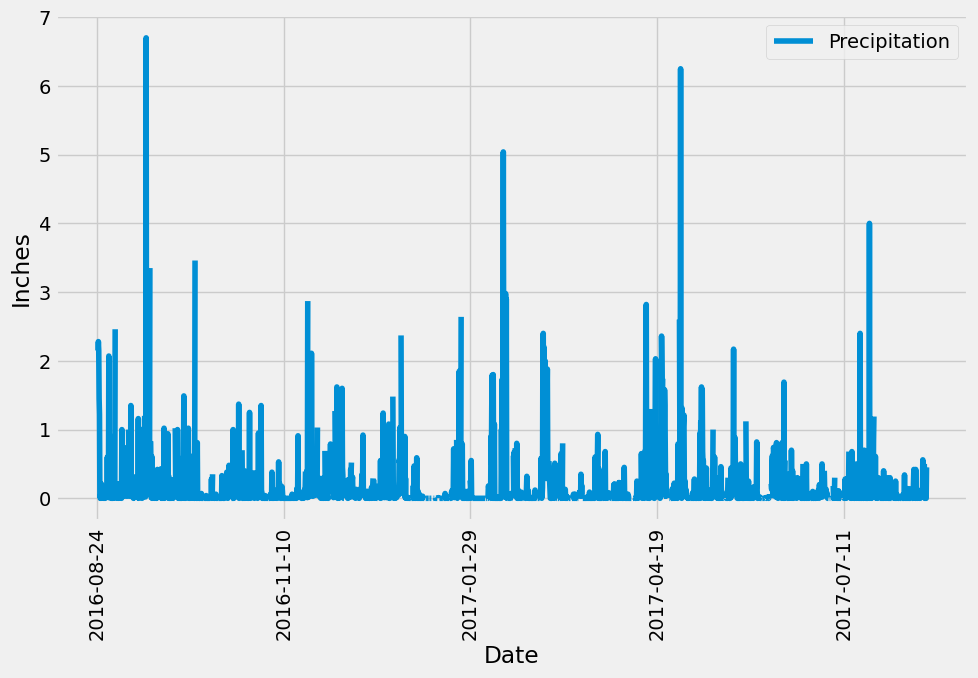

<Figure size 640x480 with 0 Axes>

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent = dt.datetime(2017, 8, 23)

# Calculate the date one year from the last date in data set.
one_year_before = most_recent - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_before).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation).set_index('date')

# Sort the dataframe by date
precipitation_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(10,7))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(["Precipitation"])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#Save plot as figure
plt.savefig('precipitation_analysis.png')

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = precipitation_df.describe()
summary_stats

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
number_stations = session.query(station.station).count()

print(f'Number of stations: {number_stations}')

Number of stations: 9


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

print(f'Most active stations in descending order: {active_stations}')

Most active stations in descending order: [('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0][0]
most_active_temps = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
            filter(measurement.station == most_active).all()

print(f'Most active station: {most_active} \nMinimum temperature: {most_active_temps[0][0]} \nMaximum temperature: {most_active_temps[0][1]} \nAverage temperature: {most_active_temps[0][2]}')

Most active station: USC00519281 
Minimum temperature: 54.0 
Maximum temperature: 85.0 
Average temperature: 71.66378066378067


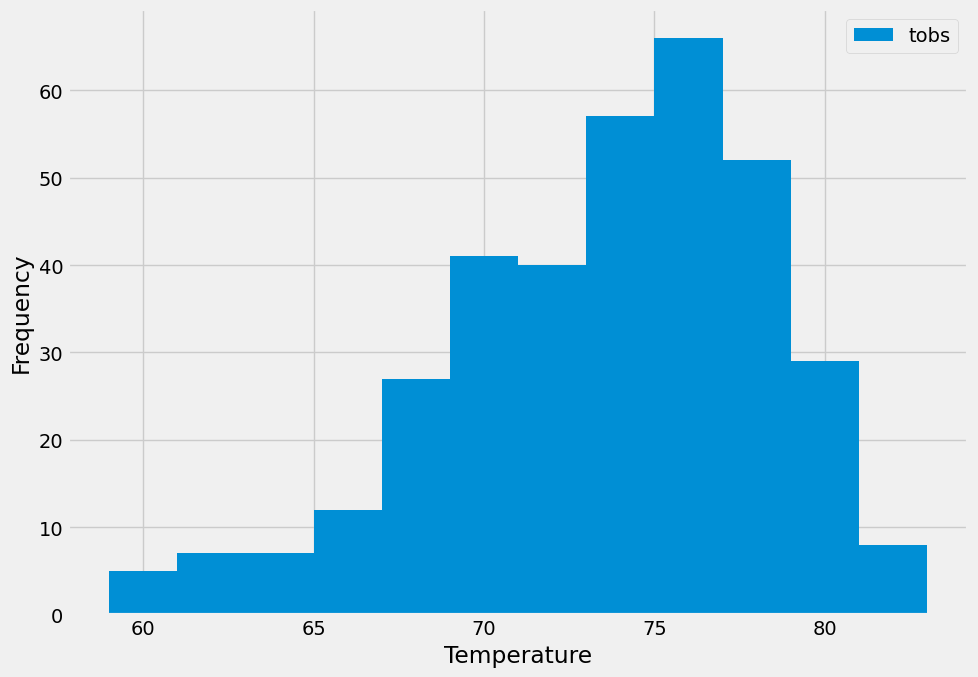

<Figure size 640x480 with 0 Axes>

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#First retrieve the date and temperature during the last year for the most active station
most_active_12_months = session.query(measurement.tobs).filter(measurement.date >= one_year_before, measurement.station == most_active).all()

#Then save results as a dataframe
most_active_12_months_df = pd.DataFrame(most_active_12_months)

#Plot the data
most_active_12_months_df.plot.hist(bins=12, figsize=(10,7))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#Save plot as figure
plt.savefig('station_analysis.png')

# Close session

In [18]:
# Close Session
session.close()